# Web Scraping job offers to find most in-demand programming languages 

## Setting up

#### Importing libraries

In [4]:
# external
import requests  # makes HTTP requests
from bs4 import BeautifulSoup  # makes it easy to scrape information from web pages
from selenium import webdriver  # automates web browser interaction
import pandas as pd  # data analysis and manipulation tool
import advertools as adv  # provides options for text analysis
import matplotlib.pyplot as plt  # creates visualizations 
import seaborn as sns # creates visualizations
from wordcloud import WordCloud  # generates word clouds 

# built-in
import os  # provides a way of using operating system dependent functionality
import re  # provides regular expression matching operations
import time  # provides various time-related functions
from collections import (
    Counter,
)  # provides specialized container datatypes - here a dict subclass for counting hashable objects
import random  # implements pseudo-random number generators

#### Setting up project folders

In [5]:
# Defining current folder as our main directory
dirname = os.getcwd()

# location folders variables
data_raw = dirname + "\\data\\raw\\"
data_interim = dirname + "\\data\\interim\\"
data_processed = dirname + "\\data\\processed\\"
figures = dirname + "\\reports\\figures\\"


# checking if folder doesn't exist already, then create it.
folders = [data_raw, 
           data_interim, 
           data_processed,
           figures]

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        with open(folder + '.gitkeep', 'w') as fp: # create .gitkeep file
            pass
        print(f"Directory Created:{folder}\n")

Directory Created:c:\Users\33671\Documents\Python\Job_Offer_Scraping\reports\figures\



#### Defining inputs

In [6]:
# specifying variables input for searching
job_title_input = "Data Analyst"
location_input = "France"

## Finding job offers urls

#### Generating initial url based on inputs

In [7]:
# trasnforming the inputs to a valid format for the url
job_title_key = "%20".join(job_title_input.split(" "))
location_key = "%20".join(location_input.split(" "))

In [8]:
# generating the initial linkedin url
url = f"https://www.linkedin.com/jobs/search?keywords={job_title_key}&location={location_key}"

Since the content of the page loads while scrolling, we can't scrap the page directly. Otherwise we would only get the first 25 job offers.

#### Scrolling through the page, then Scraping

In [11]:
# Web scrapper for infinite scrolling page
driver = webdriver.Firefox()
driver.get(url)
time.sleep(2)  # Allow 2 seconds for the web page to open
scroll_pause_time = (
    2  # You can set your own pause time. My laptop is a bit slow so I use 2 sec
)
screen_height = driver.execute_script(
    "return window.screen.height;"
)  # get the screen height of the web
i = 1

while True:
    # scroll one screen height each time
    driver.execute_script(
        "window.scrollTo(0, {screen_height}*{i});".format(
            screen_height=screen_height, i=i
        )
    )
    i += 1
    time.sleep(scroll_pause_time)
    # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
    scroll_height = driver.execute_script("return document.body.scrollHeight;")
    # Break the loop when the height we need to scroll to is larger than the total scroll height
    if (screen_height) * i > scroll_height:
        break

In [15]:
# creating soup object
soup = BeautifulSoup(driver.page_source, "html.parser")

In [8]:
# # Exploring the list of all links from the page. Select code and "CTRL + /" to activate
# for link in soup_initial_page.find_all('a'):
#    print(link.get('href'))

After exploring the soup object, we can see that the page contains multiple links. 

We will only keep those related to job offers. They can be dinstinguished from the rest since they contain: `linkedin.com/jobs/`

#### Extracting all links found

In [8]:
# Creating the empty list variable
job_links = []

# For loop that iterates over all the <li> tags
for h in soup.findAll("li"):
    # looking for anchor tag inside the <li>tag
    a = h.find("a")
    try:
        # looking for href inside anchor tag
        if "href" in a.attrs:
            # storing the value of href in a separate variable
            link = a.get("href")
            # appending the url to the output list
            job_links.append(link)
    # if the list does not have a anchor tag or does not have a href params we pass
    except:
        pass

print(f"Number of links extracted: {len(job_links)}")

Number of links extracted: 186


#### Extracting only Job Offers urls

I strangely don't always get the same number of job offers from the first page of results on Linkedin site. Sometimes I get 170 offers, sometimes 175 etc. 
Still, it I added a warning in case I don't get at least 150 job links. Below that number, it usually means that the scrolling code snippet hasn't worked properly. 

In [9]:
job_links = [link for link in job_links if "linkedin.com/jobs/" in link]
print(f"Number of job offers links: {len(job_links)}")


if len(job_links) > 150:
    print("This is the expected number of links")
else:
    print("Warning: this is not the expected number of links")

Number of job offers links: 175
This is the expected number of links


## Scraping job offers
After inspecting linkedin pages, we see that the actual content of the page is hosted between `show-more-less-html__markup` class. This is what we will look for to populate the job offers content.

In [10]:
# scraping URLs' contents and combining into one string
# creating text string
words_str = ""
job_info_str = ""
i = 0

# try/except to avoid mistakes
time.sleep(random.uniform(2.0, 4.0))
try:
    for index, link in enumerate(job_links):
        # looping through the links
        req = requests.get(link)
        # taking into account non 200 responses to try again with a bigger timer
        if req:
            i += 1
        else:
            print(req.status_code)
            # time.sleep(5)
            # req = requests.get(link) # try again on the same link
        # converting to BeautifulSoup
        soup_job_offer = BeautifulSoup(req.text)
        # extracting job content (within a div with a specific class) and job info (within a script with a specific type)
        job_content = soup_job_offer.find(
            "div", class_="show-more-less-html__markup"
        ).text
        job_info = soup_job_offer.find(
            "script", type="application/ld+json"
        ).text  # not used
        # appending to a string and converting to lowercase
        words_str = f"{words_str} {job_content}".lower()
        job_info_str = f"{job_info_str} {job_info}".lower()  # not used
        # pausing for few seconds to avoid 'error 429 too many requests'. Also using random to be safe
        time.sleep(random.uniform(2.0, 4.0))

except Exception as e:
    pass

# previewing strings contents
print(f"This an overview of the string generated:\n {words_str[:400]}")
print(f"\nNumber of characters countained - including spaces: {len(words_str)}")
print(f"\nNumber of HTTP 200 responses: {i}")

This an overview of the string generated:
  
        at teads, we do quality and responsible advertising, at scale. we invented outstream video advertising and now have a reach of 1,9 billion unique users per month powered by an end-to-end proprietary platform. we foster a sustainable advertising and media ecosystem by funding quality journalism and respectfully connecting brands to consumers.to innovate, we have created a strong company c

Number of characters countained - including spaces: 23290

Number of HTTP 200 responses: 6


## Plotting a global word cloud

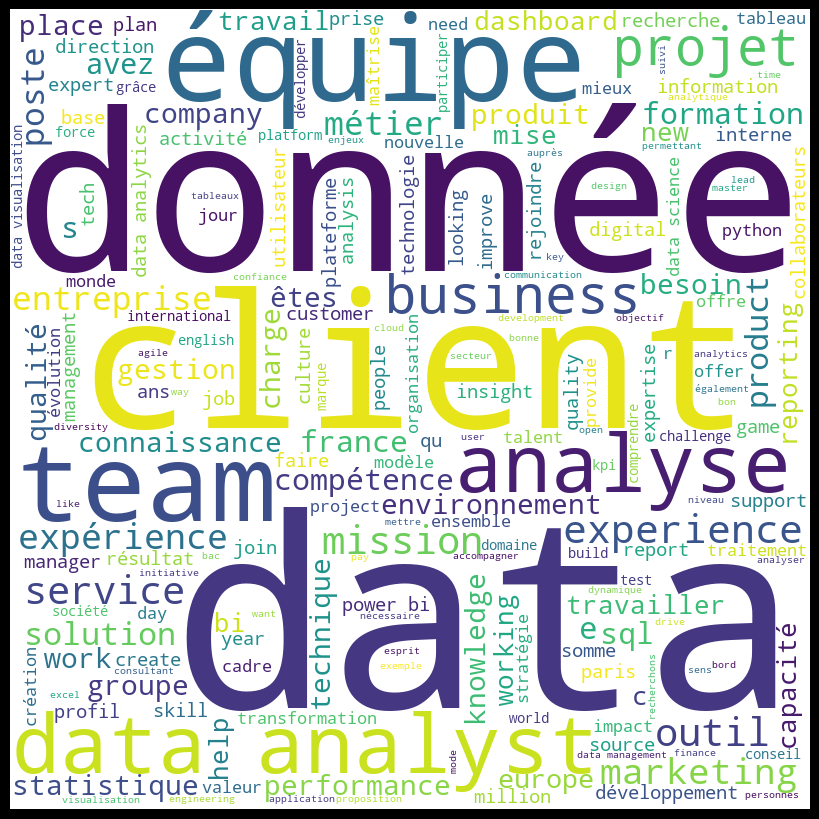

In [12]:
# plotting word cloud
# joining the sets of stopwords: English and French
sw_en_fr = adv.stopwords["english"].union(adv.stopwords["french"]).union({"d", "l"})

# generating word cloud with WordCloud module
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=sw_en_fr,
    min_font_size=10,
).generate(words_str)

# plotting the WordCloud image with matplotlib
plt.figure(figsize=(8, 8), facecolor="black")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# printing the plot
plt.show()

## Creating a dataframe

In [13]:
# creating a list from the string we had
words_list = words_str.split()

# creating a pandas dataframe from the list, transformed to a dictionnary. I need to look into it to make something less ugly
df_words = pd.DataFrame.from_dict([Counter(words_list)]).T

# renaming and sorting the df
df_words.rename(columns={0: "word_count"}, inplace=True)
df_words.index.names = ["word"]
df_words.reset_index(inplace=True)
df_words.sort_values(by=["word_count"], inplace=True, ascending=False)

# Overview of the result
print(
    f"{len(words_str)} characters string converted to {df_words.shape[0]} unique worlds and {df_words['word_count'].sum()} total occurences\n"
)
print(f"Overview of the dataframe:\n {df_words.head()}")

347752 characters string converted to 10829 unique worlds and 50849 total occurences

Overview of the dataframe:
       word  word_count
1033    de        2197
1041    et        1384
1031   des         892
5      and         812
15    data         731


## Generating raw csv files

This could be useful if we want to do a broader analysis later on

In [14]:
# generating a raw csv file with timestamp including in the name
# using the convention _ to delimit units and - to delimit words from the same limit
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = (
    "raw-words_"
    + job_title_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + location_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + timestr
    + ".csv"
)
print(f"file name: {file_name}")

df_words.to_csv(data_raw + file_name, index=True)

file name: raw-words_data-analyst_france_20221118-132816.csv


## Finding what programming languages employers are looking for

We will use a wikipedia page to ensure we have an updated list of programming languages

In [15]:
programming_languages_page = requests.get(
    "http://en.wikipedia.org/wiki/List_of_programming_languages"
)

# ensure the get request is successful
# if we use a requests.models.Response instance in a conditional expression, it evaluates to True if the status code is between 200 and 400, and False otherwise
if programming_languages_page:
    print("Success!")
else:
    print("An error has occurred.")

Success!


In [16]:
soup_programming_languages = BeautifulSoup(programming_languages_page.text)

langs = []

# parse all the links.
for link in soup_programming_languages.find_all("a"):
    # making it break on the Last link after Z++ which is "List of programming languages"
    if link.get_text() == "List of programming languages":
        break
    if link.get_text() == "edit":
        pass
    else:
        langs.append(link.get_text())

# find u'See also'
see_also_index_ = langs.index("See also")
# strip out headers
langs = langs[see_also_index_ + 1 :]

# convert list to lower-case
langs = [lang.lower() for lang in langs]

# converting list to set
langs = set(langs)

# removing languages with ambiguous names or the ones that I'm collecting by mistake (alphabet links etc.)
removelist = [
    "plus",
    "es",
    "d",
    "help",
    "media",
    "go",
    "claire",
    "simple",
    "category",
    "b",
    "clean",
    "français",
    "source",
    "e",
    "toi",
    "beta",
    "small",
    "developers",
    "focus",
    "joy",
    "processing",
    "resources",
    "contributions",
    "reason",
    "rapid",
    "hope",
    "scratch",
    "self",
    "pilot",
    "ml",
    "pipelines",
    "dc",
    "abc",
    "inform",
    "ease",
    "basic",
    "lean",
    "skill",
    "read",
    "statistics",
    "tea",
    "dog",
    "definitions",
    "logo",
    "history",
    "talk",
    "mad",
    "chill",
    "s",
    "t",
    "hack",
    "cool",
]
langs.difference_update(removelist)

print(f"Programming languages populated: {len(langs)}")

Programming languages populated: 772


## Searching for most in-demand programming languages

Results should be interpreted with caution since I'm looking for exact matching. For example, if a job offer includes "C-sharp", it won't popup since it's present as C# in the  `langs` set. 

In [17]:
# keeping only the programming languages from the df_word
df_langs_in_demand = df_words[df_words["word"].isin(langs)]

# reformating the index
df_langs_in_demand = df_langs_in_demand.reset_index()
df_langs_in_demand.drop("index", axis=1)

,word,word_count
0,sql,53
1,python,21
2,r,6
3,sas,3
4,pure,2
5,spark,2
6,c,1
7,scala,1
8,f,1


In [27]:
df_langs_in_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       9 non-null      int64 
 1   word        9 non-null      object
 2   word_count  9 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 344.0+ bytes


<AxesSubplot:xlabel='word', ylabel='word_count'>

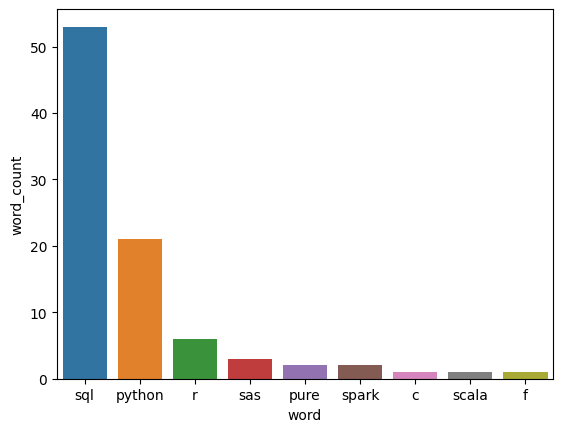

In [34]:
sns.barplot(data = df_langs_in_demand,
              x = 'word',
              y = 'word_count',
              #color = "lightblue"
              )

In [18]:
# generating a csv file
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = (
    "langs_in_demand_"
    + job_title_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + location_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + timestr
    + ".csv"
)
print(f"file name: {file_name}")

df_langs_in_demand.to_csv(data_processed + file_name, index=True)

file name: langs_in_demand_data-analyst_france_20221118-133429.csv


## Searching for most in-demand dashboarding tools

In [19]:
tools = [
    "power",
    "tableau",
    "cognos",
    "excel",
    "matlab",
    "qlikview",
    "splunk",
    "grafana",
    "looker",
    "domo",
    "dundas",
    "yellowfin",
    "zoho",
    "plotly",
    "kibana",
    "graphite",
    "graylog",
]

# keeping only the programming languages from the df_word
df_tools_in_demand = df_words[df_words["word"].isin(tools)]

# reformating the index
df_tools_in_demand = df_tools_in_demand.reset_index()
df_tools_in_demand.drop("index", axis=1)

,word,word_count
0,power,36
1,tableau,16
2,excel,5
3,qlikview,1
4,looker,1


<AxesSubplot:xlabel='word', ylabel='word_count'>

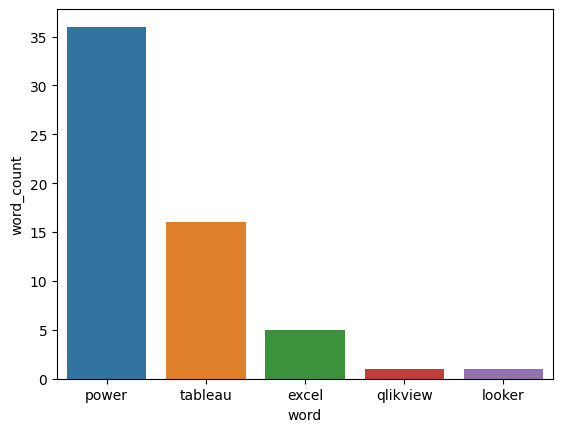

In [35]:
sns.barplot(data = df_tools_in_demand,
              x = 'word',
              y = 'word_count',
              #color = "lightblue"
              )

In [36]:
# generating a csv file
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = (
    "langs_in_demand_"
    + job_title_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + location_input.replace(" ", "-").replace(",", "").lower()
    + "_"
    + timestr
    + ".csv"
)
print(f"file name: {file_name}")

df_tools_in_demand.to_csv(data_processed + file_name, index=True)

file name: langs_in_demand_data-analyst_france_20221118-134510.csv
